In [111]:
from __future__ import division
from dolfin import *
import math
import numpy as np


#!sudo pip2.7 install easydict
from easydict import EasyDict as edict

%matplotlib inline

In [112]:
# =============================================================================
# CONSTANTS and PARAMETERS
# =============================================================================

ndp = edict({'U': 1.0,
 'asthenosphere': 0.0,
 'cohesion': 0.21023999999999998,
 'eta1': 1000.0000000000001,
 'eta2': 0.01,
 'fa': 0.4663076581549986,
 'g': 1.0,
 'rho': 1.3921567199999998})

In [113]:
# =============================================================================
# MESH
# =============================================================================

#width, height = 4, 1 # domain width and height
# option "crossed" stands for crossed diagonals (number of elements=XDIV*ZDIV*4)
mesh = RectangleMesh(Point(-2, 0), Point(2.0, 1.0), 128, 32, "crossed")
cell = triangle
norm = FacetNormal(mesh) # definition of an outer normal

ez = Constant((0, -1)) #gravity vector



In [114]:
coords = mesh.coordinates()
coords

array([[-2.      ,  0.      ],
       [-1.96875 ,  0.      ],
       [-1.9375  ,  0.      ],
       ..., 
       [ 1.921875,  0.984375],
       [ 1.953125,  0.984375],
       [ 1.984375,  0.984375]])

In [115]:
# =============================================================================
# FUNCTIONAL SET-UP
# =============================================================================
# Taylor-Hood elements: linear Lagrange elements for pressure
# and quadratic Lagrange elements for velocity
#P = FunctionSpace(mesh, "Lagrange", 1)
#V = VectorFunctionSpace(mesh, "Lagrange", 2)
#W = MixedFunctionSpace([P, V])

In [116]:
# =============================================================================
# Define function spaces
# =============================================================================

V = VectorElement("Lagrange", mesh.ufl_cell(), 2)
P = FiniteElement("Lagrange", mesh.ufl_cell(), 1)

#V = VectorElement('P', tetrahedron, 2)
#P = FiniteElement('P', tetrahedron, 1)

TH = V * P
W = FunctionSpace(mesh, TH)

In [117]:
# Define test functions
#w = TestFunction(W)
#omega, phi = split(w)

In [118]:
# Define solution functions - current solution
#u = Function(W)
#v, p = split(u)

In [119]:
w = Function ( W )

(u , p ) = split ( w )
(v , q ) = TestFunctions ( W )

In [120]:
#plot(v, interactive=True)


In [121]:
ndp.eta1, ndp.eta2

(1000.0000000000001, 0.01)

In [122]:
# =============================================================================
# INITIAL CONDITIONS - & Material distribution
# =============================================================================
u_init = Expression(("0", "0","0"), degree=2) # zero


density=Constant(ndp.rho)


tol = 1e-14

eta_1 = ndp.eta1
eta_2 = ndp.eta2

notchWidth = 1./16

#Fast but opaque C++ string, 
#eta = Expression('x[1] < 1./16 + tol && x[0] < 1./16 && x[0] > -1./16 ? eta_1 : eta_2', degree=0,
#               tol=tol, eta_1=eta_1, eta_2=eta_2)


class Eta(Expression):
    def set_eta_values(self, eta_1, eta_2):
        self.eta_1, self.eta_2 = eta_1, eta_2
    def eval(self, value, x):
        "Set value[0] to value at point x"
        tol = 1E-14
        if (x[1] < 1./16 + tol) and (x[0] <= 1./16 + tol ) and (x[0] >= -1./16 + tol ):
        #if (x[1] < 1./16 + tol) and (x[0] <= 1./16 + tol ) :
            value[0] = self.eta_2
        else:
            value[0] = self.eta_1
# Initialize kappa
etaExpr = Eta(degree=1)
etaExpr.set_eta_values(ndp.eta1, eta_2)
etaExpr.eta_1, etaExpr.eta_2

(1000.0000000000001, 0.01)

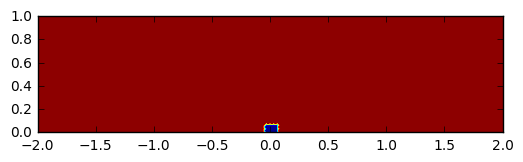

In [123]:
# =============================================================================
# Plotting expressions
# =============================================================================


X = FunctionSpace(mesh, P)

f = Function(X)
f.interpolate(etaExpr)
plot(f )

In [124]:
# =============================================================================
# BOUNDARY CONDITIONS
# =============================================================================

# Define boundaries
def left(x):
    return near(x[0], -2)

def right(x):
    return near(x[0], 2)


def bottom(x):
    return near(x[1], 0)

def top(x):
    return near(x[1], 1)




noslip = Constant((0, 0))
freeslip = Constant(0)
leftBC = Constant((1.0, 0))
rightBC = Constant((-1.0, 0))

#W.sub(1) ~ Pressure DoFs
#W.sub(0) ~ Vel DoFs


bc_v_bot = DirichletBC(W.sub(0).sub(1), freeslip, bottom)
bc_v_left = DirichletBC(W.sub(0), leftBC, left)
bc_v_right = DirichletBC(W.sub(0), rightBC,right)


# fixing the pressure at the top boundary

bc_p = DirichletBC(W.sub(1),
                    Expression("0", degree=1),
                    "near(x[0],0) && near(x[1],0)",
                    method="pointwise")


# collection of BCs for mechanical part of the problem
bcs_W = [bc_p, bc_v_bot, bc_v_left, bc_v_right]


In [125]:
# =============================================================================
# Rheology
# =============================================================================

def eijeij(u):
    """calculate second invariant of the strainrate tensor"""
    return sqrt(0.5*(inner(sym(nabla_grad(u)), sym(nabla_grad(u)))))

def viscosity(w):
    
    u, p = w.split()
    
    viscosityl = ndp.eta1
    viscosityp = 1e-10 + ndp.cohesion/(eijeij(u) + 1e-10)
    return 1./(1./etaExpr + 1./viscosityp)
 
    
#our viscosity function will return a Fenics /UFl Exprssion
#the expression must be projected to a finite element space before we can visualize it:    


#vtest = viscosity(u)    
V1 = FunctionSpace(mesh, 'P', 1)
#vtest = project(vtest, V1)
#plot(vtest, title='viscosity')
#print(type(vtest))

In [127]:
# =============================================================================
# Newton solver
# =============================================================================

# =============================================================================
# WEAK FORMULATION
# =============================================================================


# Combined Stokes, continuitycontinuity equation
#F = nabla_div(u)*q*dx + p*nabla_div(v)*dx \
#      - 2.*viscosity(w)*inner((nabla_grad(u)
#      + transpose(nabla_grad(u))), transpose(nabla_grad(v)))*dx \
#      + density*inner(ez, v)*dx
        
    
#the above symbolic weak form works, but we can formulate this more succinctly
#https://fenicsproject.org/pub/course/lectures/2016-logg-chalmers-phdcourse/lecture_03_static_nonlinear_pdes.pdf


#epsilon = 2*sym(grad(u))

#F = (viscosity(w)*inner(epsilon, grad(v)) \
#    - div(u)*q - div(v)*p)*dx \
#    - density*inner(ez, v)*dx

    
 
#from spiegelman paper

#bv = (inner(sym(grad(v)), 2.*viscosity(w)*sym(grad(u))) - div(v)*p - density*inner(ez, v))
bv = (inner(sym(grad(v)), 2.*viscosity(w)*sym(grad(u))) - div(v)*p)
bp = -q*div(u)


rv = bv*dx
rp = bp*dx

F = rv + rp

In [128]:
# Solve problem
solve ( F == 0 , w , bcs_W )

Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.


RuntimeError: 

*** -------------------------------------------------------------------------
*** DOLFIN encountered an error. If you are not able to resolve this issue
*** using the information listed below, you can ask for help at
***
***     fenics-support@googlegroups.com
***
*** Remember to include the error message listed below and, if possible,
*** include a *minimal* running example to reproduce the error.
***
*** -------------------------------------------------------------------------
*** Error:   Unable to solve nonlinear system with NewtonSolver.
*** Reason:  Newton solver did not converge because maximum number of iterations reached.
*** Where:   This error was encountered inside NewtonSolver.cpp.
*** Process: 0
*** 
*** DOLFIN version: 2016.2.0
*** Git changeset:  0f003bc07ee5fd583fb956245016d5972b80fea1
*** -------------------------------------------------------------------------


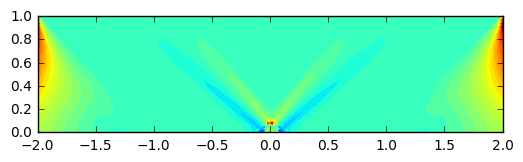

In [129]:
# NBVAL_IGNORE_OUTPUT

u, p = w.split()
axes = plot(p)


In [130]:
# Split the mixed solution using deepcopy
# (needed for further computation on coefficient vector)
(u, p) = w.split(True)

print("Norm of velocity coefficient vector: %.15g" % u.vector().norm("l2"))
print("Norm of pressure coefficient vector: %.15g" % p.vector().norm("l2"))

Norm of velocity coefficient vector: 157.939531947778
Norm of pressure coefficient vector: 41.687059968099


In [131]:
File('u.pvd') << u
File('p.pvd') << p

In [71]:
J_W = derivative(F, w)
# create nonlinear problem
problem_W = NonlinearVariationalProblem(F, w, bcs_W, J_W)
solver_W = NonlinearVariationalSolver(problem_W)
prm_W = solver_W.parameters
# Newton solver parameters (mechanical part of the problem)
prm_W["newton_solver"]["relative_tolerance"] = 1E-7
#prm_W["newton_solver"]["absolute_tolerance"] = 1E-2
prm_W["newton_solver"]["maximum_iterations"] = 5
prm_W["newton_solver"]["relaxation_parameter"] = 1.0
#prm_W["newton_solver"]["convergence_criterion"] = 'incremental'
prm_W["newton_solver"]["convergence_criterion"] = "residual"

prm_W["newton_solver"]["linear_solver"] = "mumps"
set_log_level(PROGRESS)

In [72]:
info(prm_W, True)


In [73]:
# initializing velocity-pressure
w.interpolate(u_init)
v, p = w.split()
#info("Solve momentum equation")
solver_W.solve()

RuntimeError: 

*** -------------------------------------------------------------------------
*** DOLFIN encountered an error. If you are not able to resolve this issue
*** using the information listed below, you can ask for help at
***
***     fenics-support@googlegroups.com
***
*** Remember to include the error message listed below and, if possible,
*** include a *minimal* running example to reproduce the error.
***
*** -------------------------------------------------------------------------
*** Error:   Unable to solve nonlinear system with NewtonSolver.
*** Reason:  Newton solver did not converge because maximum number of iterations reached.
*** Where:   This error was encountered inside NewtonSolver.cpp.
*** Process: 0
*** 
*** DOLFIN version: 2016.2.0
*** Git changeset:  0f003bc07ee5fd583fb956245016d5972b80fea1
*** -------------------------------------------------------------------------


In [100]:

u, p = w.split()

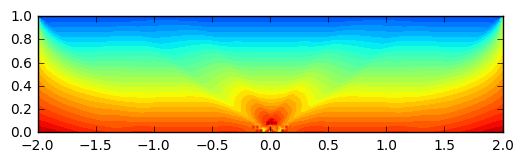

In [101]:
plot(p, scalarbar = True )

In [102]:
#plot(mesh, title="Finite element mesh")
#plot(v,scale = 0.2)

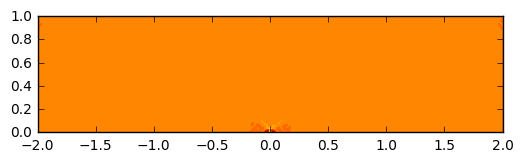

In [103]:
#Plot strain rate tensor components

W2 = TensorFunctionSpace(mesh, "Lagrange", 2)
sigma_w = project(sym(nabla_grad(u)), W2)

#sym(nabla_grad(v)
plot(sigma_w[0, 0], interactive=True) 

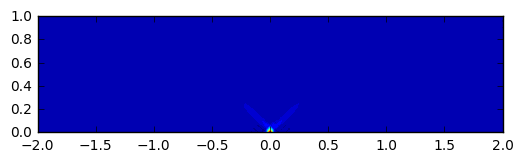

In [104]:
#Plot strain rate invariant components
#not we don't have to project this guy

eij =  sqrt(0.5*(inner(sym(nabla_grad(u)), sym(nabla_grad(u)))))
plot(eij , interactive=True, scalarbar = True ) 

In [108]:
#But we do need to project it to get it values at nodes
eijFEM = project(eij , V1)



In [34]:
from IPython.display import HTML

In [42]:
#HTML(X3DOM().html(v ))

In [179]:
info(prm_W, True)

In [180]:
#bc.homogenize()
b = assemble(F_W)
#bc.apply(b)
print('residual: {0}'.format(b.norm('l2')))

residual: 0.616968884074


In [159]:
#bcs_W.homogenize()
b = assemble(F_W)
#bcs_W.apply(b)
print('residual: {0}'.format(b.norm('l2')))

residual: 0.618680716571


In [160]:
1.239e-01

0.1239

In [109]:
# Save solution to file
u, p = w.split()
File('u.pvd') << u
File('p.pvd') << p
#File('mesh.pvd') << mesh
File('eij.pvd') << eijFEM

In [224]:
ls

Untitled.ipynb  mesh000000.vtu  p000000.vtu  u000000.vtu  v000000.vtu
mesh.pvd        p.pvd           u.pvd        v.pvd


In [266]:
help(plot)

Help on function plot in module dolfin.common.plotting:

plot(object, *args, **kwargs)
    Plot given object.
    
    *Arguments*
        object
            a :py:class:`Mesh <dolfin.cpp.Mesh>`, a :py:class:`MeshFunction
            <dolfin.cpp.MeshFunction>`, a :py:class:`Function
            <dolfin.functions.function.Function>`, a :py:class:`Expression`
            <dolfin.cpp.Expression>, a :py:class:`DirichletBC`
            <dolfin.cpp.DirichletBC>, a :py:class:`FiniteElement
            <ufl.FiniteElement>`, or a :py:class:`MultiMesh
            <dolfin.cpp.MultiMesh>`.
    
    *Examples of usage*
        In the simplest case, to plot only e.g. a mesh, simply use
    
        .. code-block:: python
    
            mesh = UnitSquare(4,4)
            plot(mesh)
    
        Use the ``title`` argument to specify title of the plot
    
        .. code-block:: python
    
            plot(mesh, tite="Finite element mesh")
    
        It is also possible to plot an element
    
  

In [47]:
#mesh.meshes.

In [125]:
uvals = eijFEM.vector().array()
xyvals = mesh.coordinates()
#xyvals = dofs_x
xvals = xyvals[:,0]
yvals= xyvals[:,1]

xx = np.linspace(-2,2, 100)
yy = np.linspace(0,1, 25)

XX, YY = np.meshgrid(xx,yy)


from scipy.interpolate import griddata
uu = griddata(np.column_stack((xvals, yvals)), uvals, np.dstack((XX, XX)))

uvals = eijFEM.vector().array()
xyvals = mesh.coordinates()
#xyvals = dofs_x
xvals = xyvals[:,0]
yvals= xyvals[:,1]

xx = np.linspace(-2,2, 100)
yy = np.linspace(0,1, 25)

XX, YY = np.meshgrid(xx,yy)
